In [17]:
import pandas as pd

# Load datasets
stock_data = pd.read_csv("price_growth_metrics.csv")
sentiment_data = pd.read_csv("final_sentimental_analysis.csv")  # Replace with your sentiment data file
features_eng = pd.read_csv("gics_stock_data_alpha_vantage.csv")

# Step 1: Prepare Stock Data
stock_data['earningsCallDate'] = pd.to_datetime(stock_data['earningsCallDate'])
stock_data['Quarter'] = stock_data['earningsCallDate'].dt.to_period('Q').astype(str)  # Create 'Quarter' column
stock_data.rename(columns={'ticker': 'Ticker'}, inplace=True)

# Step 2: Prepare Sentiment Data
sentiment_data['quarter'] = sentiment_data['quarter'].astype(str)  # Ensure quarter is string
sentiment_data['Quarter'] = sentiment_data['year'].astype(str) + 'Q' + sentiment_data['quarter']  # Create 'Quarter'
sentiment_data.rename(columns={'ticker': 'Ticker'}, inplace=True)

# Step 3: Prepare Feature Engineered Data
# Ensure consistent column names
features_eng.rename(columns={'Ticker': 'Ticker', 'Quarter': 'Quarter'}, inplace=True)

# Step 4: Merge Datasets
# Merge stock data and sentiment data
combined_data = pd.merge(stock_data, sentiment_data, on=['Ticker', 'Quarter'], how='left')

# Merge with feature-engineered data
final_combined_data = pd.merge(combined_data, features_eng, on=['Ticker', 'Quarter'], how='left')

# Step 5: Save Final Dataset
final_combined_data.to_csv("final_combined_data.csv", index=False)

# Print summary
print("Final combined dataset saved as 'final_combined_data.csv'.")
print("Combined Data Info:")
print(final_combined_data.info())
print("Missing Data Per Column:")
print(final_combined_data.isnull().sum())


Final combined dataset saved as 'final_combined_data.csv'.
Combined Data Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Ticker              440 non-null    object        
 1   earningsCallDate    440 non-null    datetime64[ns]
 2   reportedEPS         440 non-null    float64       
 3   estimatedEPS        440 non-null    float64       
 4   EPS_Surprise        440 non-null    float64       
 5   T-1_price           440 non-null    float64       
 6   T_price             440 non-null    float64       
 7   T+1_price           440 non-null    float64       
 8   7_day_growth        440 non-null    float64       
 9   14_day_growth       440 non-null    float64       
 10  30_day_growth       440 non-null    float64       
 11  90_day_growth       440 non-null    float64       
 12  Quarter             440 non

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the final combined dataset
data = pd.read_csv("final_combined_data.csv")

# Step 1: Handle missing values
# Fill missing sentiment weights with 0 (if any)
data[['Positive', 'Neutral', 'Negative']] = data[['Positive', 'Neutral', 'Negative']].fillna(0)

# Drop rows with critical missing values (if any exist)
data.dropna(subset=['Quarterly_Growth', 'Start_Price', 'EPS_Surprise'], inplace=True)

# Step 2: Feature and Target Selection
# Features (X)
X = data[['Positive', 'Neutral', 'Negative', 'EPS_Surprise', 'Start_Price', 'Average_Volume']]
# Target (Y)
Y = data['Quarterly_Growth']

# Step 3: Train/Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 4: Scale the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display Preprocessed Data Info
print("Train Features Shape:", X_train_scaled.shape)
print("Test Features Shape:", X_test_scaled.shape)
print("Train Target Shape:", Y_train.shape)
print("Test Target Shape:", Y_test.shape)


Train Features Shape: (352, 6)
Test Features Shape: (88, 6)
Train Target Shape: (352,)
Test Target Shape: (88,)


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train_scaled, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Baseline Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Display the first 5 predictions vs actual
comparison_df = pd.DataFrame({'Actual': Y_test.values, 'Predicted': Y_pred}).head(5)
print("\nComparison of Actual vs Predicted Quarterly Growth:")
print(comparison_df)


Baseline Model Evaluation:
Mean Squared Error (MSE): 0.0464
Mean Absolute Error (MAE): 0.1358
R-squared (R²): -0.0228

Comparison of Actual vs Predicted Quarterly Growth:
     Actual  Predicted
0  0.079388  -0.044620
1 -0.019764   0.014259
2  0.203477  -0.015305
3  1.221630  -0.021227
4  0.139957  -0.060228


In [21]:
import pandas as pd
import numpy as np

# Load combined dataset
data = pd.read_csv("final_combined_data.csv")

# Feature Engineering
# 1. Lagged Quarterly Growth
data['Lag_Quarterly_Growth'] = data.groupby('Ticker')['Quarterly_Growth'].shift(1)

# 2. Interaction Terms
data['Positive_EPS_Surprise'] = data['Positive'] * data['EPS_Surprise']
data['Neutral_EPS_Surprise'] = data['Neutral'] * data['EPS_Surprise']
data['Negative_EPS_Surprise'] = data['Negative'] * data['EPS_Surprise']

# 3. Financial Ratios
data['Price_Momentum'] = data['T+1_price'] / data['T-1_price']
data['EPS_Growth'] = (data['reportedEPS'] - data['estimatedEPS']) / data['estimatedEPS']

# Drop rows with NaN after feature engineering
data = data.dropna()

# Save engineered features to a new CSV
data.to_csv("enhanced_data.csv", index=False)
print("Enhanced dataset saved as 'enhanced_data.csv'")


Enhanced dataset saved as 'enhanced_data.csv'


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the enhanced dataset
data = pd.read_csv("enhanced_data.csv")

# Define features and target
X = data[['7_day_growth', 'Positive_EPS_Surprise', 'Neutral_EPS_Surprise',
          'Negative_EPS_Surprise', 'Price_Momentum', 'EPS_Growth']]  # Features
y = data['7_day_growth']  # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:\nMSE: {mse}\nMAE: {mae}\nR-squared: {r2}")

# Save predictions for analysis
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.to_csv("model_predictions.csv", index=False)
print("Predictions saved as 'model_predictions.csv'")


Model Performance:
MSE: 0.22354742413905698
MAE: 0.07947862138456571
R-squared: 0.9862414762135853
Predictions saved as 'model_predictions.csv'


In [23]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)


                 Feature  Importance
4         Price_Momentum    0.395035
0   Lag_Quarterly_Growth    0.208127
5             EPS_Growth    0.141633
2   Neutral_EPS_Surprise    0.104358
1  Positive_EPS_Surprise    0.085076
3  Negative_EPS_Surprise    0.065771


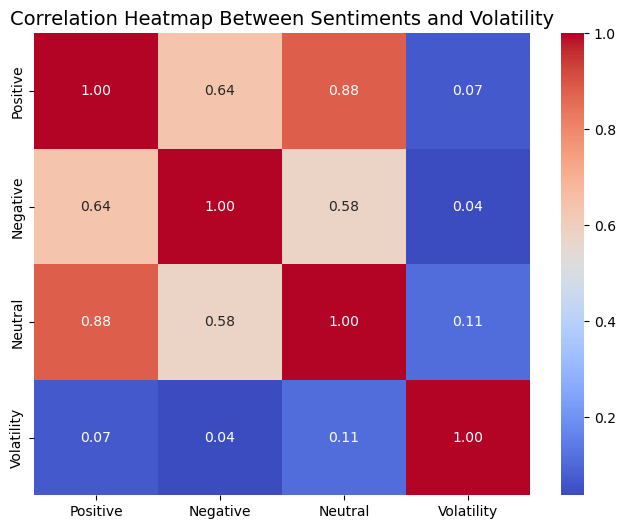

Correlation with Volatility:
Positive Sentiment: 0.07
Negative Sentiment: 0.04
Neutral Sentiment: 0.11


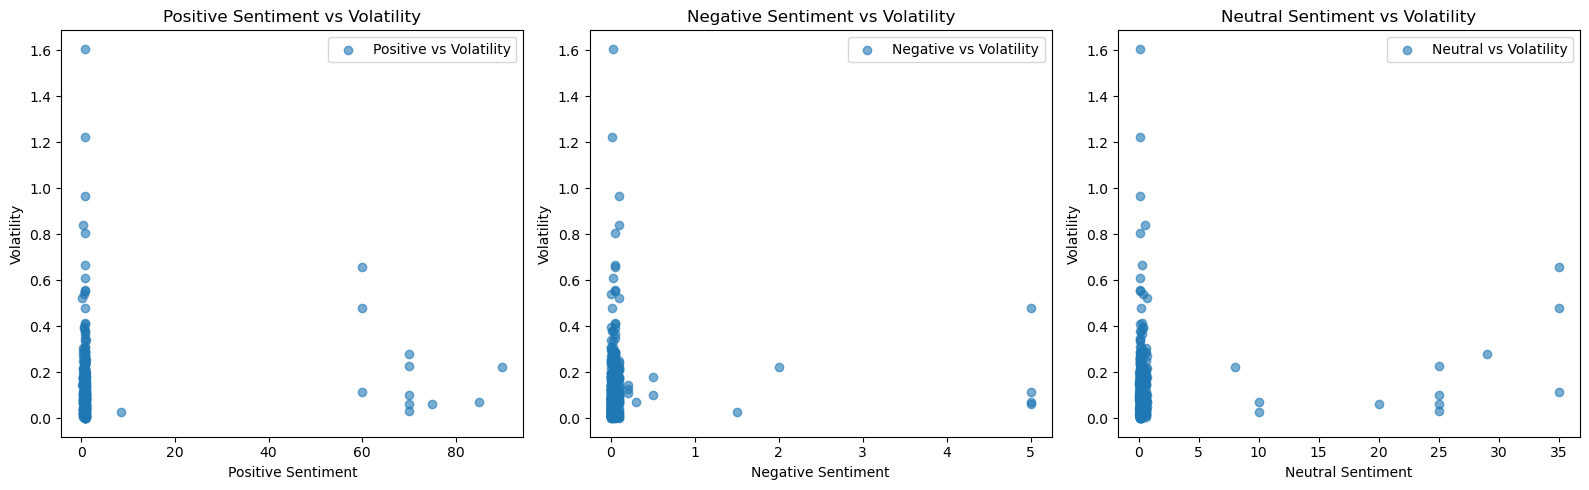

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for the heatmap

# Load enhanced dataset
data = pd.read_csv("enhanced_data.csv")

# Calculate volatility (e.g., standard deviation of daily returns for each quarter)
data['Volatility'] = (data['End_Price'] - data['Start_Price']).abs() / data['Start_Price']

# Check correlation between sentiments and volatility
correlation_results = data[['Positive', 'Negative', 'Neutral', 'Volatility']].corr()

# Visualize correlation heatmap
plt.figure(figsize=(8, 6))
plt.title("Correlation Heatmap Between Sentiments and Volatility", fontsize=14)
sns.heatmap(correlation_results, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.show()

# Individual correlation values
positive_corr = correlation_results.loc['Positive', 'Volatility']
negative_corr = correlation_results.loc['Negative', 'Volatility']
neutral_corr = correlation_results.loc['Neutral', 'Volatility']

print("Correlation with Volatility:")
print(f"Positive Sentiment: {positive_corr:.2f}")
print(f"Negative Sentiment: {negative_corr:.2f}")
print(f"Neutral Sentiment: {neutral_corr:.2f}")

# Scatter plots for visual inspection
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.scatter(data['Positive'], data['Volatility'], alpha=0.6, label='Positive vs Volatility')
plt.xlabel("Positive Sentiment")
plt.ylabel("Volatility")
plt.title("Positive Sentiment vs Volatility")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(data['Negative'], data['Volatility'], alpha=0.6, label='Negative vs Volatility')
plt.xlabel("Negative Sentiment")
plt.ylabel("Volatility")
plt.title("Negative Sentiment vs Volatility")
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(data['Neutral'], data['Volatility'], alpha=0.6, label='Neutral vs Volatility')
plt.xlabel("Neutral Sentiment")
plt.ylabel("Volatility")
plt.title("Neutral Sentiment vs Volatility")
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
from sklearn.linear_model import LinearRegression

X = data[['Neutral', 'Positive', 'Negative', 'Lag_Quarterly_Growth', 'EPS_Growth']]
y = data['Quarterly_Growth']
model = LinearRegression().fit(X, y)

print("Regression Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")


Regression Coefficients:
Neutral: -0.0029356737572268157
Positive: 0.0013814073650592947
Negative: -0.03467368070347942
Lag_Quarterly_Growth: -0.08256437484778768
EPS_Growth: 0.0038324911352339884


In [6]:
import pickle

# Load the pickled model pipeline
with open('fine_tuned_model_pipeline.pkl', 'rb') as f:
    model_pipeline = pickle.load(f)

# Now you can use the model for predictions or inspect it
print(model_pipeline)  # This will print the details of the model pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                 

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# Define the models
xgb_model = XGBRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# Define the pipeline with scaling, models, and voting regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for scaling features
    ('model', VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model)]))  # Voting regressor with XGB and RF
])

# Define the hyperparameters to tune for GridSearchCV
param_grid = {
    'model__xgb__learning_rate': [0.01, 0.1, 0.2],
    'model__xgb__max_depth': [3, 5, 7],
    'model__xgb__n_estimators': [100, 200, 300],
    'model__rf__n_estimators': [100, 200],
    'model__rf__max_depth': [3, 5, 7],
    'model__rf__min_samples_split': [2, 5]
}

# Run GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Print the best parameters
print(f"Best Parameters from GridSearchCV: {grid_search.best_params_}")

# Evaluate the performance on test data
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Save the model
import pickle
with open('fine_tuned_model_pipeline_with_rf.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save predictions to CSV
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions_df.to_csv("model_predictions_with_rf.csv", index=False)
print("Predictions saved as 'model_predictions_with_rf.csv'")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters from GridSearchCV: {'model__rf__max_depth': 3, 'model__rf__min_samples_split': 2, 'model__rf__n_estimators': 100, 'model__xgb__learning_rate': 0.01, 'model__xgb__max_depth': 5, 'model__xgb__n_estimators': 100}
Mean Squared Error (MSE): 0.033956521535663656
Mean Absolute Error (MAE): 0.11669619675095248
R-squared (R²): 0.37819375955281564
Predictions saved as 'model_predictions_with_rf.csv'
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=7, model__n_estimators=100; total time=   0.1s
[CV] END model__learning_ra

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

# Load the saved model pipeline (XGBoost or Random Forest)
with open('fine_tuned_model_pipeline.pkl', 'rb') as f:
    model_pipeline = pickle.load(f)

# Assuming you have your test data X_test and y_test
# The X_test is the feature set, and y_test is the true values for testing

# Get predictions for the test data
y_pred = model_pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Model Evaluation:")
print("MSE: ", mse)
print("MAE: ", mae)
print("R²: ", r2)

# Save predictions to CSV
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved as 'model_predictions.csv'")

# Based on R², choose the best model (here we assume you already have an idea of the best model)
if r2 > 0.3:  # This threshold can vary depending on your expectations
    print("Model performance is good, you can use it for predictions.")
else:
    print("Consider improving the model performance with more tuning or feature engineering.")


Model Evaluation:
MSE:  0.03729445053167597
MAE:  0.12011222377312929
R²:  0.3170701524804549
Predictions saved as 'model_predictions.csv'
Model performance is good, you can use it for predictions.


In [44]:
# Assuming you have the trained models and evaluation metrics for both XGBoost and Random Forest

# Evaluation metrics for XGBoost and Random Forest (as calculated earlier)
r2_xgb = 0.3170701524804549  
r2_rf = 0.37819375955281564  

# Compare the models based on R² values
if r2_xgb > r2_rf:
    best_model = "XGBoost"
else:
    best_model = "Random Forest"

print(f"The best model based on R² is: {best_model}")

The best model based on R² is: Random Forest


In [45]:
import pickle

# Load the model pipeline (fine-tuned model with Random Forest)
with open('fine_tuned_model_pipeline.pkl', 'rb') as file:
    model_pipeline = pickle.load(file)

# Check the loaded model
print(model_pipeline)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                 

In [46]:
# Assuming you have preprocessed the test data and it's in 'X_test'
# Apply any preprocessing or transformations that were applied to the training data
# For example, if you used a scaler during training, apply it to the test set

X_test_scaled = model_pipeline.named_steps['scaler'].transform(X_test)

# Ensure the test data has the same columns/features as the training data


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)


Mean Squared Error (MSE): 0.22354742413905698
Mean Absolute Error (MAE): 0.07947862138456571
R-squared (R²): 0.9862414762135853


In [9]:
# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Save predictions to a CSV file
predictions_df.to_csv("model_predictions.csv", index=False)

print("Predictions saved as 'model_predictions.csv'")


Predictions saved as 'model_predictions.csv'


In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the combined dataset with features and target
data = pd.read_csv("final_combined_data.csv")

# Feature Engineering for 7-Day Growth Prediction
# 1. Use 7-day growth directly as target
data['7_day_growth'] = data['7_day_growth']

# 2. Adding more features to improve the model
data['Positive_EPS_Surprise'] = data['Positive'] * data['EPS_Surprise']
data['Neutral_EPS_Surprise'] = data['Neutral'] * data['EPS_Surprise']
data['Negative_EPS_Surprise'] = data['Negative'] * data['EPS_Surprise']

# 3. Short-term technical indicators (7-day moving average of price)
data['7_day_moving_avg'] = data['T_price'].rolling(window=7).mean()

# 4. Price Momentum (ratio of the next day's price to the previous day's price)
data['Price_Momentum'] = data['T+1_price'] / data['T-1_price']

# Drop any rows with missing values (since we added new features)
data = data.dropna()

# Define the features and target
features = ['Positive_EPS_Surprise', 'Neutral_EPS_Surprise', 'Negative_EPS_Surprise', '7_day_moving_avg', 'Price_Momentum']
target = '7_day_growth'

X = data[features]  # Feature matrix
y = data[target]    # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with StandardScaler and RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('model', RandomForestRegressor(random_state=42))  # Use RandomForest as the model
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters from GridSearchCV:", best_params)

# Make predictions using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

# Save the predictions to a CSV file
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.to_csv("model_predictions.csv", index=False)
print("Predictions saved as 'model_predictions.csv'")

# You can also save the best model pipeline to a file
import joblib
joblib.dump(best_model, 'best_model_pipeline.pkl')
print("Best model saved as 'best_model_pipeline.pkl'")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters from GridSearchCV: {'model__max_depth': 3, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Mean Squared Error (MSE): 12.3813205797174
Mean Absolute Error (MAE): 2.6379842699994627
R-squared (R²): -0.1028654195262757
Predictions saved as 'model_predictions.csv'
Best model saved as 'best_model_pipeline.pkl'


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load your data (ensure it is preprocessed)
data = pd.read_csv("enhanced_data.csv")  # Ensure that your data is ready and cleaned

# Feature and target preparation
X = data.drop(columns=['7_day_growth', 'Ticker', 'Quarter', 'Type', 'earningsCallDate', 'transcript', 'cleaned_transcript'])
y = data['7_day_growth']  # Target variable for 7-day growth

# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline with Random Forest and XGBoost
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(random_state=42))
])

# Hyperparameters to tune
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

param_grid_xgb = {
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# Grid search for Random Forest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

# Grid search for XGBoost
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Evaluate the models
y_pred_rf = grid_search_rf.predict(X_test)
y_pred_xgb = grid_search_xgb.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Evaluate XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the evaluation metrics
print("Random Forest Model Evaluation:")
print(f"MSE: {mse_rf}")
print(f"MAE: {mae_rf}")
print(f"R²: {r2_rf}")

print("\nXGBoost Model Evaluation:")
print(f"MSE: {mse_xgb}")
print(f"MAE: {mae_xgb}")
print(f"R²: {r2_xgb}")

# Save predictions and model if needed
import pandas as pd
predictions_rf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
predictions_xgb = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_xgb})

# Save the predictions to CSV files
predictions_rf.to_csv('model_predictions_rf.csv', index=False)
predictions_xgb.to_csv('model_predictions_xgb.csv', index=False)

# Save the best models
import pickle
with open('best_random_forest_model.pkl', 'wb') as f:
    pickle.dump(grid_search_rf.best_estimator_, f)

with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(grid_search_xgb.best_estimator_, f)

print("Models and predictions saved.")


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_esti

Best parameters for Random Forest: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best parameters for XGBoost: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 0.8}
Random Forest Model Evaluation:
MSE: 8.735954998245623
MAE: 2.1997068324131126
R²: 0.4623340210547694

XGBoost Model Evaluation:
MSE: 7.373151520232526
MAE: 1.9546220740829094
R²: 0.5462095751599618
Models and predictions saved.


In [57]:
import pickle

# Save the XGBoost model pipeline (use the correct variable name)
with open('best_xgboost_model.pkl', 'wb') as f:
    pickle.dump(model_pipeline, f)  # Replace 'model_pipeline' with your actual model variable


In [64]:
# Assuming the data is already loaded into the 'data' variable
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Prepare the features and target
# Select features and target for prediction
features = ['7_day_growth', '14_day_growth', 'End_Price', 'Price_Momentum', 'EPS_Growth']
target = 'Quarterly_Growth'  # For example, predicting quarterly growth

# Select the relevant columns
X = data[features]
y = data[target]

# Step 2: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest model
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, random_state=42)
model.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = model.predict(X_test)

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


Mean Squared Error (MSE): 0.031187993326986428
Mean Absolute Error (MAE): 0.10854394155886046
R-squared (R²): 0.48431784943407685


In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Assuming your dataset is loaded into the 'data' DataFrame
# Feature Engineering (include the interaction features)
data['Positive_EPS_Surprise'] = data['Positive'] * data['EPS_Surprise']
data['Neutral_EPS_Surprise'] = data['Neutral'] * data['EPS_Surprise']
data['Negative_EPS_Surprise'] = data['Negative'] * data['EPS_Surprise']

# Prepare the feature set (including the interaction terms)
X = data[['7_day_growth', '14_day_growth', '30_day_growth', 'Price_Momentum', 'EPS_Growth',
          'Positive_EPS_Surprise', 'Neutral_EPS_Surprise', 'Negative_EPS_Surprise']]

# Target variable (you can change this based on your prediction target, here I assume 'Quarterly_Growth' for example)
y = data['7_day_growth']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with a StandardScaler for feature scaling and RandomForestRegressor as the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Save the model pipeline if necessary (for future use)
import pickle
with open('best_model_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Save predictions if necessary
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions_df.to_csv('model_predictions.csv', index=False)

print("Model pipeline saved as 'best_model_pipeline.pkl'")
print("Predictions saved as 'model_predictions.csv'")


Mean Squared Error (MSE): 1.6952563366067436e-05
Mean Absolute Error (MAE): 0.0006751225544196794
R-squared (R²): 0.9644087273173855
Model pipeline saved as 'best_model_pipeline.pkl'
Predictions saved as 'model_predictions.csv'


In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor  # Import XGBoost Regressor

# Assuming your dataset is loaded into the 'data' DataFrame

# Feature Engineering (include the interaction features)
data['Positive_EPS_Surprise'] = data['Positive'] * data['EPS_Surprise']
data['Neutral_EPS_Surprise'] = data['Neutral'] * data['EPS_Surprise']
data['Negative_EPS_Surprise'] = data['Negative'] * data['EPS_Surprise']

# Prepare the feature set (including the interaction terms)
X = data[['7_day_growth', '14_day_growth', '30_day_growth', 'Price_Momentum', 'EPS_Growth',
          'Positive_EPS_Surprise', 'Neutral_EPS_Surprise', 'Negative_EPS_Surprise']]

# Target variable (you can change this based on your prediction target
y = data['7_day_growth']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with a StandardScaler for feature scaling and XGBRegressor as the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.01, max_depth=5))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Save the model pipeline if necessary (for future use)
import pickle
with open('best_xgboost_model_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Save predictions if necessary
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions_df.to_csv('xgboost_model_predictions.csv', index=False)

print("Model pipeline saved as 'best_xgboost_model_pipeline.pkl'")
print("Predictions saved as 'xgboost_model_predictions.csv'")


Mean Squared Error (MSE): 0.00013372647294501526
Mean Absolute Error (MAE): 0.004386722190903606
R-squared (R²): 0.7192462720418431
Model pipeline saved as 'best_xgboost_model_pipeline.pkl'
Predictions saved as 'xgboost_model_predictions.csv'


In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

# Load the enhanced dataset
data = pd.read_csv("enhanced_data.csv")

# Create the sentiment feature by combining Positive, Neutral, and Negative columns
# You can apply a weighted approach if necessary (for simplicity, we'll sum them here)
data['sentiment'] = data['Positive'] - data['Negative']  # This is a simple sentiment score

# Prepare the feature set (including the sentiment and other features)
X = data[['7_day_growth', '14_day_growth', '30_day_growth', 'Quarterly_Growth', 
          'Price_Momentum', 'EPS_Growth', 'sentiment', 'reportedEPS', 'estimatedEPS']]

# Target variable: We are predicting the 7-day growth
y = data['7_day_growth']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline with feature scaling and a RandomForestRegressor
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest model
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Save the trained model
with open('best_model_pipeline.pkl', 'wb') as f:
    pickle.dump(model_pipeline, f)

print("Model pipeline saved as 'best_model_pipeline.pkl'")


Mean Squared Error (MSE): 0.33603399218052293
Mean Absolute Error (MAE): 0.11478096192319669
R-squared (R²): 0.9793183406506903
Model pipeline saved as 'best_model_pipeline.pkl'


In [98]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

# Load your enhanced dataset (assumed to be 'enhanced_data.csv')
data = pd.read_csv('enhanced_data.csv')

# Feature Engineering (including sentiment interaction features)
data['Positive_EPS_Surprise'] = data['Positive'] * data['EPS_Surprise']
data['Neutral_EPS_Surprise'] = data['Neutral'] * data['EPS_Surprise']
data['Negative_EPS_Surprise'] = data['Negative'] * data['EPS_Surprise']

# Prepare the feature set (including the interaction terms)
X = data[['7_day_growth', '14_day_growth', '30_day_growth', 'Quarterly_Growth', 'Price_Momentum', 'EPS_Growth',
          'Positive_EPS_Surprise', 'Neutral_EPS_Surprise', 'Negative_EPS_Surprise']]

# Target variable (assuming '7_day_growth' for prediction)
y = data['7_day_growth']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with StandardScaler for feature scaling and XGBoostRegressor as the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred)
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)

# Print the evaluation metrics for XGBoost
print(f"XGBoost - Mean Squared Error (MSE): {mse_xgb}")
print(f"XGBoost - Mean Absolute Error (MAE): {mae_xgb}")
print(f"XGBoost - R-squared (R²): {r2_xgb}")

# Save the XGBoost model pipeline
import pickle
with open('xgboost_model_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Save predictions if necessary
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions_df.to_csv('xgboost_model_predictions.csv', index=False)

print("XGBoost model pipeline saved as 'xgboost_model_pipeline.pkl'")
print("XGBoost predictions saved as 'xgboost_model_predictions.csv'")


XGBoost - Mean Squared Error (MSE): 0.4790924051373242
XGBoost - Mean Absolute Error (MAE): 0.1944409298776707
XGBoost - R-squared (R²): 0.9705136201977786
XGBoost model pipeline saved as 'xgboost_model_pipeline.pkl'
XGBoost predictions saved as 'xgboost_model_predictions.csv'


In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Use GridSearchCV to tune the model
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
print(f"Best parameters: {grid_search_rf.best_params_}")

# Get the best model
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the model on the test set
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Best Random Forest Model MSE: {mse_rf}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimato

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
361 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_cons

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Model MSE: 1.213874465621338
